In [1]:
import sys, os

import matplotlib.pyplot as plt
import numpy as np
import torch
from pytorch_lightning import seed_everything
from tqdm import tqdm, trange

from risk_biased.scene_dataset.scene_plotter import ScenePlotter

sys.path.append(os.path.join(os.getcwd(), "../scripts/eval_scripts"))
from evaluate_prediction_planning_stack import (
    get_cfg_and_planner,  
    get_scene_and_ado_trajectory, 
    get_ego_state_history_and_target_trajectory
)

In [2]:
###### Paramaeters ######

load_from = "3svdfk8y" # "<set desired model ID (i.e., wandb run ID)>" # "1a5a1rv0"

seed = 0
num_episodes = 500
num_prediction_samples = 128

scene_type = "safer_fast"

risk_in_predictor = True
optimize_policy = True
stack_risk_level = 0.95

episode_id = 1

In [3]:
###### Setup Planner ######

sys.argv = sys.argv[:1] + ["--load_from", load_from, "--load_last"]

cfg, planner = get_cfg_and_planner(load_from="")

if not planner.solver.params.mean_warm_start == False:
    print(
        "switching to mean_warm_start = False for open-loop evaluation (i.e. without re-planning)"
    )
    planner.solver.params.mean_warm_start = False

Loading last checkpoint.
Loading existing dataset at /home/jeanmercat/Codes/risk_biased/risk_biased/scene_dataset/../../data/scene_dataset_005.
switching to mean_warm_start = False for open-loop evaluation (i.e. without re-planning)


/home/jeanmercat/miniconda3/envs/risk_biased/lib/python3.7/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/jeanmercat/Codes/risk_biased/risk_biased/utils/load_model.py:197: UserWarning: When loading the model, the configuration was changed to match the configuration of the pre-trained model to be loaded.
    The value of 'risk_weight' is now '10' instead of '1'.
  warnings.warn(warning_message)


In [4]:
###### Setup Scene ######

(
    scene,
    ado_state_history_batch,
    ado_state_future_batch,
) = get_scene_and_ado_trajectory(
    cfg, scene_type=scene_type, num_episodes=num_episodes
)

(
    ego_state_history,
    ego_state_target_trajectory,
) = get_ego_state_history_and_target_trajectory(cfg, scene)

/home/jeanmercat/Codes/risk_biased/risk_biased/scene_dataset/scene.py:186: UserWarning: Some of the given pedestrian initial positions are outside of the road range
  "Some of the given pedestrian initial positions are outside of the road range"


In [5]:
ado_state_history = ado_state_history_batch[episode_id]
ado_state_future = ado_state_future_batch[episode_id]

In [6]:
###### Optimize Ego Trajectory ######

if optimize_policy:
    solver_info = planner.solver.solve(
        planner.predictor,
        ego_state_history,
        ego_state_target_trajectory,
        ado_state_history,
        planner.normalizer,
        num_prediction_samples=num_prediction_samples,
        verbose=False,
        risk_level=stack_risk_level,
        resample_prediction=False,
        risk_in_predictor=risk_in_predictor,
    )
else:
    planner.solver.reset()

In [7]:
ego_position_planned_trajectory = planner.dynamics_model.simulate(
    ego_state_history[..., -1],
    planner.solver.control_sequence
).position.squeeze(0)

ego_position_trajectory = torch.cat(
    (ego_state_history.position.squeeze(0), ego_position_planned_trajectory),
    dim=0
)
ado_position_trajectory = torch.cat(
    (ado_state_history.position.squeeze(0), ado_state_future.position.squeeze(0)),
    dim=0
)
ado_predictions = planner.solver.fetch_latest_prediction().position

In [8]:
if stack_risk_level == 0.0:
    risk_level_directory_description = "risk_level_0.0"
else:
    risk_level_directory_description = f"risk_level_{stack_risk_level}_in_{'predictor' if risk_in_predictor else 'planner'}"
save_dir = os.path.join(
    os.getcwd(), 
    f"trajectory_{load_from}_{scene_type}_seed_{seed}",
    f"episode_{episode_id}_of_{num_episodes}",
    f"num_samples_{num_prediction_samples}",
    risk_level_directory_description)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

100%|██████████| 45/45 [00:17<00:00,  2.58it/s]


Figures saved to /home/jeanmercat/Codes/risk_biased/notebooks/trajectory_3svdfk8y_safer_fast_seed_0/episode_1_of_500/num_samples_128/risk_level_0.95_in_predictor


0

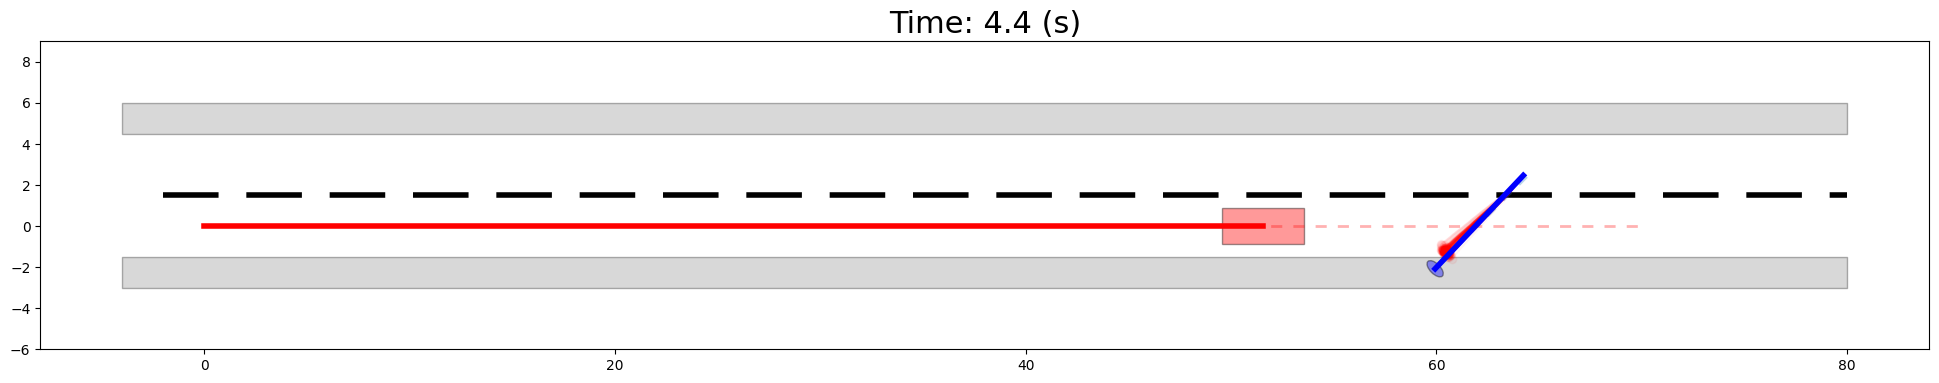

In [10]:
fig, ax = plt.subplots()

plotter = ScenePlotter(scene, ax=ax)
fig.set_size_inches(h=scene.road_width / 3 + 1, w=scene.road_length / 3)

for time_idx in trange(cfg.num_steps_future):
    ax.clear()
    time = cfg.dt * (cfg.num_steps + time_idx)
    plotter.draw_scene(episode_id, time=time, ego_pos_x = ego_position_planned_trajectory[time_idx][0].item())
    plotter.draw_all_trajectories(
        prediction=ado_predictions, label="Predicted Trajectory", color="red", final_index=time_idx
    )
    ax.set_title(f"Time: {cfg.dt * time_idx :.1f} (s)", fontsize=22)
    ax.plot([ego_position_trajectory[0][0].item(), ego_position_trajectory[cfg.num_steps + time_idx][0].item()],
            [0, 0], linewidth=4.0, color="red")
    ax.plot([ado_position_trajectory[0][0].item(), ado_position_trajectory[cfg.num_steps + time_idx][0].item()],
            [ado_position_trajectory[0][1].item(), ado_position_trajectory[cfg.num_steps + time_idx][1].item()],
            linewidth=4.0, color="blue")
    plt.savefig(os.path.join(save_dir, f"plot_{time_idx:03d}.png"))
    # plt.savefig(os.path.join(save_dir, f"plot_{time_idx}.svg"))

print(f"Figures saved to {save_dir}")
# Might need to run #sudo apt-get install imagemagick in the terminal to get this next line to work
os.system("convert -delay 10 -loop 0 " + os.path.join(save_dir, "plot_*.png") + " " + os.path.join(save_dir, "animation.gif"))